Compiling model...
'compile' took 0.000267 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.49e-02, 0.00e+00, 4.95e-01, 1.27e-02, 5.34e-03]    [4.92e-02, 0.00e+00, 4.95e-01, 1.27e-02, 5.34e-03]    []  
1000      [1.65e-08, 1.19e-12, 6.47e-13, 1.43e-10, 3.45e-10]    [1.27e-08, 1.19e-12, 6.47e-13, 1.43e-10, 3.45e-10]    []  
2000      [1.15e-09, 1.60e-14, 2.22e-14, 1.89e-12, 7.97e-12]    [8.36e-10, 1.60e-14, 2.22e-14, 1.89e-12, 7.97e-12]    []  
3000      [9.67e-10, 2.81e-16, 5.00e-14, 2.98e-13, 8.15e-13]    [8.40e-10, 2.81e-16, 5.00e-14, 2.98e-13, 8.15e-13]    []  
4000      [9.63e-10, 5.42e-16, 7.99e-15, 1.97e-13, 5.04e-13]    [8.56e-10, 5.42e-16, 7.99e-15, 1.97e-13, 5.04e-13]    []  
5000      [9.62e-10, 4.20e-16, 5.55e-15, 1.49e-13, 5.12e-13]    [8.57e-10, 4.20e-16, 5.55e-15, 1.49e-13, 5.12e-13]    []  
6000      [9.61e-10, 2.81e-16, 4.35e-14, 1.98e-13, 3.92e-13]    [8.

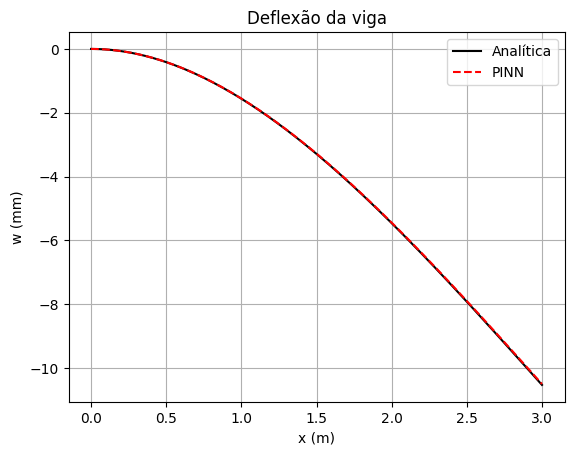

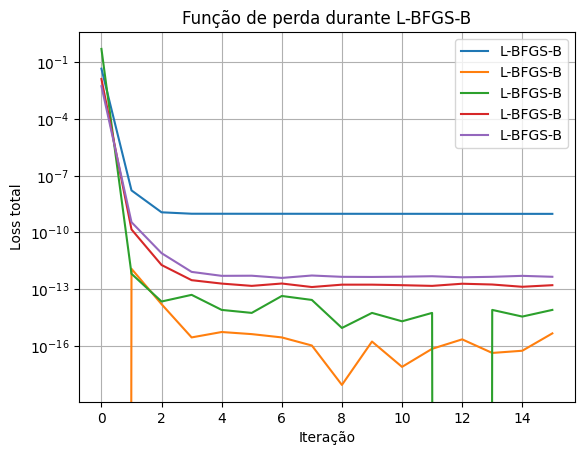

Solução analítica:
  Deflexão máxima w(L) = -10.533246 mm
  Ângulo máximo θ(L)   = -0.005267 rad ≈ -0.301755 graus
Solução PINN:
  Deflexão máxima w(L) = -10.504313 mm
  Ângulo máximo θ(L)   = -0.005254 rad ≈ -0.301035 graus
-0.010504312813282013
-0.01053324555628703

Erro relativo:
  Deflexão: 0.27 %
  Ângulo:   0.24 %


In [ ]:
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- Parâmetros do problema ----------
L = 3.0                               # Comprimento da viga [m]
E = 2.10e11                           # Módulo de Young [Pa]
I = 6.51e-5                           # Momento de inércia [m^4]
p = 1.6e4                             # Carga concentrada [N]

# ---------- Equação diferencial: EI w''''(x) = 0 ----------
def pde(x, y):
    d2y = dde.grad.hessian(y, x, i=0, j=0)           # w''
    d4y = dde.grad.hessian(d2y, x, i=0, j=0)         # w''''
    return d4y

# ---------- Geometria ----------
geom = dde.geometry.Interval(0.0, L)

# ---------- Condições de contorno ----------
def on_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

def on_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# w(0) = 0
bc_w0 = dde.DirichletBC(geom, lambda x: 0.0, on_left)

# w'(0) = 0
bc_theta0 = dde.OperatorBC(
    geom,
    lambda x, y, dy: dde.grad.jacobian(y, x, i=0, j=0),
    on_left,
)

# w''(L) = 0
bc_momentL = dde.OperatorBC(
    geom,
    lambda x, y, dy: dde.grad.hessian(y, x, i=0, j=0),
    on_right,
)

# w'''(L) = p/(EI)
def shear_condition(x, y, dy):
    d2y = dde.grad.hessian(y, x, i=0, j=0)
    d3y = dde.grad.jacobian(d2y, x, i=0, j=0)
    return d3y - torch.tensor(p / (E * I), dtype=torch.float32)

bc_shearL = dde.OperatorBC(geom, shear_condition, on_right)

bcs = [bc_w0, bc_theta0, bc_momentL, bc_shearL]

# ---------- Dados ----------
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=500,
    num_boundary=50,
    num_test=200,
)

# ---------- Rede neural ----------
layer_size = [1] + [30] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# ---------- Modelo ----------
model = dde.Model(data, net)
#model.compile("adam", lr=0.001)

#N_iter = 10
#step = 5000
#losshistory, train_state = model.train(iterations=N_iter, display_every=step)

# ---------- (Opcional) Refinamento com L-BFGS-B ----------
model.compile("L-BFGS-B")
losshistory2, train_state2 = model.train()

# ---------- Pós-processamento ----------
x = np.linspace(0, L, 200).reshape(-1, 1)
w_pred = model.predict(x)

# Solução analítica
w_exact = -p * x**2 * (3*L - x) / (6 * E * I)

# ---------- Gráfico comparativo ----------
plt.figure()
plt.plot(x, w_exact * 1000, "k-", label="Analítica")
plt.plot(x, w_pred * 1000, "r--", label="PINN")
plt.xlabel("x (m)")
plt.ylabel("w (mm)")
plt.title("Deflexão da viga")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Gráfico da loss  ADAM----------
# loss_total = np.array(losshistory.loss_train)
# plt.figure()
# plt.semilogy(loss_total)
# plt.xlabel("Época")
# plt.ylabel("Loss total")
# plt.title("Evolução da função de perda (Adam)")
# plt.grid(True, which="both")
# plt.show()

# Perdas ao longo do L-BFGS-B

loss_lbf = np.array(losshistory2.loss_train)
plt.figure()
plt.semilogy(loss_lbf, label="L-BFGS-B")
plt.xlabel("Iteração")
plt.ylabel("Loss total")
plt.title("Função de perda durante L-BFGS-B")
plt.grid(True, which="both")
plt.legend()
plt.show()


# -------- Solução analítica (x = L) --------
w_exact_L = -p * L**3 / (3 * E * I)
theta_exact_L = -p * L**2 / (2 * E * I)

print(f"Solução analítica:")
print(f"  Deflexão máxima w(L) = {w_exact_L*1000:.6f} mm")
print(f"  Ângulo máximo θ(L)   = {theta_exact_L:.6f} rad ≈ {np.degrees(theta_exact_L):.6f} graus")

# -------- PINN: deflexão e ângulo em x = L --------
x_L = torch.tensor([[L]], dtype=torch.float32, requires_grad=True)

# Previsão da rede (PyTorch)
w_tensor = model.net(x_L)                      # w(L)
dw_dx = torch.autograd.grad(
    w_tensor, x_L,
    grad_outputs=torch.ones_like(w_tensor),
    create_graph=True
)[0]                                           # w'(L)

w_pinn_L = w_tensor.item()
theta_pinn_L = dw_dx.item()

print(f"Solução PINN:")
print(f"  Deflexão máxima w(L) = {w_pinn_L*1000:.6f} mm")
print(f"  Ângulo máximo θ(L)   = {theta_pinn_L:.6f} rad ≈ {np.degrees(theta_pinn_L):.6f} graus")

# -------- Erros relativos --------
erro_w = 100 * (abs(w_pinn_L - w_exact_L) / abs(w_exact_L))
erro_theta = 100* (abs(theta_pinn_L - theta_exact_L) / abs(theta_exact_L))

print(f"\nErro relativo:")
print(f"  Deflexão: {erro_w:.2f} %")
print(f"  Ângulo:   {erro_theta:.2f} %")

